# Software Vulnerability Detection using Deep Learning (Experiment Replication)

### Multicolumn experiment (All CWEs and others)

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others:
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

Converting the HDF5 files for training/validation/testing datasets to python pickle for ease of future usage

In [5]:
# Colab comes with TF pre-installed, but to be explicit:
!pip install --upgrade pip
!pip install "tensorflow<3.0,>=2.0" pandas numpy scikit-learn h5py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


<h1>Loading dataset</h1>

In [6]:
import h5py
import pandas as pd

In [8]:
# 3 datasets available

data = h5py.File("VDISC_train.hdf5",'r')
data = h5py.File("VDISC_validate.hdf5",'r')
data = h5py.File("VDISC_test.hdf5",'r')

In [9]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Create a new dataframe from the HDF5 file

In [10]:
mydf = pd.DataFrame(list(data['functionSource']))

In [11]:
mydf['CWE-119']=list(data['CWE-119']); mydf['CWE-120']=list(data['CWE-120']); mydf['CWE-469']=list(data['CWE-469']); mydf['CWE-476']=list(data['CWE-476']); mydf['CWE-other']=list(data['CWE-other'])

In [12]:
mydf.rename(columns={0:'functionSource'},inplace=True)

In [13]:
mydf.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,b'default_event_handler( \n GuiWidget *widg...,False,False,False,False,False
1,"b'krb5_krbhst_init_flags(krb5_context context,...",False,False,False,False,False
2,b'swap_info_get(swp_entry_t entry)\n{\n\tstruc...,False,False,False,False,False
3,"b'parseattribs4(char *&c, const Vec4 &ival = V...",False,False,False,False,False
4,b'generateExecCode(CompileState* comp)\n{\n ...,False,False,False,False,False


In [14]:
mydf.to_pickle("VDISC_train.pickle")
mydf.to_pickle("VDISC_validate.pickle")
mydf.to_pickle("VDISC_test.pickle")

## Exploratory Data Analysis

### Importing processed datasets

In [15]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

In [ ]:
### CONTINUE LATER

## Learning Phase

### Importing libraries

In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Tensorlfow version:  2.18.0
Eager mode:  True
GPU is NOT AVAILABLE


### Setting static and global variables

In [17]:
# Generate random seed
#myrand=np.random.randint(1, 99999 + 1)
myrand=71926
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [18]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [19]:
# Force decode all 'functionSource' entries
for df in [train, validate, test]:
    df['functionSource'] = df['functionSource'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else str(x))


In [20]:
assert all(isinstance(x, str) for x in train['functionSource'])
assert all(isinstance(x, str) for x in validate['functionSource'])
assert all(isinstance(x, str) for x in test['functionSource'])

In [21]:
# Normalize the CWE columns
for dataset in [train, validate, test]:
    for col in range(1, 6):
        dataset.iloc[:, col] = dataset.iloc[:, col].astype(bool).map({False: 0, True: 1})

# Now combine the decoded strings
x_all = pd.concat([
    train['functionSource'],
    validate['functionSource'],
    test['functionSource']
])


<ipython-input-21-8516747873ed>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         0
1         0
2         0
3         0
4         0
         ..
127414    0
127415    0
127416    0
127417    0
127418    0
Name: CWE-119, Length: 127419, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, col] = dataset.iloc[:, col].astype(bool).map({False: 0, True: 1})
<ipython-input-21-8516747873ed>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         0
1         0
2         0
3         0
4         0
         ..
127414    0
127415    0
127416    0
127417    0
127418    0
Name: CWE-120, Length: 127419, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, col] = dataset.iloc[:, col].astype(bool).map({False: 0, True: 1})


In [22]:
sum(isinstance(x, bytes) for x in x_all)

0

In [23]:
# Overview of the datasets
train.head()

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,default_event_handler( \n GuiWidget *widget...,0,0,0,0,0
1,"krb5_krbhst_init_flags(krb5_context context,\n...",0,0,0,0,0
2,swap_info_get(swp_entry_t entry)\n{\n\tstruct ...,0,0,0,0,0
3,"parseattribs4(char *&c, const Vec4 &ival = Vec...",0,0,0,0,0
4,generateExecCode(CompileState* comp)\n{\n g...,0,0,0,0,0


### Tokenizing the source codes

In [24]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(x_all)
del x_all

print('Number of tokens:', len(tokenizer.word_counts))

Number of tokens: 339126


In [25]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [26]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 1174173),
 ('0', 792702),
 ('return', 657996),
 ('i', 514827),
 ('1', 448365),
 ('int', 384147),
 ('null', 369591),
 ('the', 295008),
 ('t', 274803),
 ('n', 267021)]

### Create sequence files from the tokens

In [27]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train,
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [28]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(test['functionSource'])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test,
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [29]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences(validate['functionSource'])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate,
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [30]:
# Example data
test.iloc[0:5,1:6]

,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


### One-Hot-Enconding (OHE) on the datasets

In [31]:
y_train=[]
y_test=[]
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [32]:
# Example data
y_test[0][1:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

### Model Definition (CNN with Gaussian Noise and 5 Output Splits)

In [33]:
# Create a random weights matrix

random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [46]:
import tensorflow as tf

INPUT_SIZE = 500  # (adjust based on your tokenizer)
WORDS_SIZE = tokenizer.num_words  # or len(tokenizer.word_index)+1
random_weights = np.random.rand(WORDS_SIZE, 13)  # example, you probably loaded pre-trained weights

# Build the input
inp_layer = tf.keras.layers.Input(shape=(INPUT_SIZE,))

# Embedding + CNN
mid_layers = tf.keras.layers.Embedding(
    input_dim=WORDS_SIZE,
    output_dim=13,
    weights=[random_weights]
)(inp_layer)
mid_layers = tf.keras.layers.Conv1D(filters=256, kernel_size=9, padding='same', activation='relu')(mid_layers)
mid_layers = tf.keras.layers.MaxPooling1D(pool_size=5)(mid_layers)
mid_layers = tf.keras.layers.Dropout(0.5)(mid_layers)
mid_layers = tf.keras.layers.Flatten()(mid_layers)
mid_layers = tf.keras.layers.Dense(32, activation='relu')(mid_layers)
mid_layers = tf.keras.layers.Dense(8, activation='relu')(mid_layers)

# 5 truly separate outputs
output1 = tf.keras.layers.Dense(2, activation='softmax', name="output_1")(mid_layers)
output2 = tf.keras.layers.Dense(2, activation='softmax', name="output_2")(mid_layers)
output3 = tf.keras.layers.Dense(2, activation='softmax', name="output_3")(mid_layers)
output4 = tf.keras.layers.Dense(2, activation='softmax', name="output_4")(mid_layers)
output5 = tf.keras.layers.Dense(2, activation='softmax', name="output_5")(mid_layers)

# Final model with **5 outputs**
model = tf.keras.Model(inputs=inp_layer, outputs=[output1, output2, output3, output4, output5])

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy']  # ✅ one per output
)


print("✅ Model rebuilt correctly with 5 separate outputs.")
model.summary()


✅ Model rebuilt correctly with 5 separate outputs.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 500, 13)   │    130,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 256)  │     30,208 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 100, 256)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 256)  │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25600)     │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │    819,232 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        264 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_1 (Dense)    │ (None, 2)         │         18 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_2 (Dense)    │ (None, 2)         │         18 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_3 (Dense)    │ (None, 2)         │         18 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_4 (Dense)    │ (None, 2)         │         18 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_5 (Dense)    │ (None, 2)         │         18 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 979,794 (3.74 MB)

 Trainable params: 979,794 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

### Tensorboard Callbacks

In [35]:
## Create TensorBoard callbacks

callbackdir= 'D:\\temp\\cb'

tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir,
                         histogram_freq=1,
                         embeddings_freq=1,
                         write_graph=True,
                         write_images=True)

tbCallback.set_model(model)
mld = 'model/model-ALL-{epoch:02d}.keras'


## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld,
                                         monitor="val_loss",
                                         save_best_only=True,
                                         mode='auto',
                                         save_freq='epoch',
                                         verbose=1)

### Model Training

In [ ]:
import numpy as np
import pickle
import tensorflow as tf
import os

# 1. Create sample weights function
def make_sample_weights(y, pos_weight=5.0):
    return np.where(np.argmax(y, axis=1) == 1, pos_weight, 1.0)

# 2. Create label lists
y_train_list = [y for y in y_train]
y_val_list = [y for y in y_validate]

# 3. Create sample weight list
sample_weight_list = [make_sample_weights(y, 5.0) for y in y_train]

# 4. Print debug info
for idx, name in enumerate(model.output_names):
    print(f"Output: {name}")
    print(f"  y_train shape: {y_train_list[idx].shape}")
    print(f"  sample_weight shape: {sample_weight_list[idx].shape}")

# 5. ✅ FINAL Correct model.fit (list format!)
history = model.fit(
    x=x_train,
    y=y_train_list,                      # ✅ LIST not dict
    validation_data=(x_validate, y_val_list),  # ✅ validation as list too
    sample_weight=sample_weight_list,    # ✅ LIST sample weight
    epochs=10,
    batch_size=128,
    verbose=2,
    callbacks=[mcp, tbCallback]
)

# 6. Save history
os.makedirs('history', exist_ok=True)

with open('history/History-ALL-40EP-CNN', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Output: output_1
  y_train shape: (127419, 2)
  sample_weight shape: (127419,)
Output: output_2
  y_train shape: (127419, 2)
  sample_weight shape: (127419,)
Output: output_3
  y_train shape: (127419, 2)
  sample_weight shape: (127419,)
Output: output_4
  y_train shape: (127419, 2)
  sample_weight shape: (127419,)
Output: output_5
  y_train shape: (127419, 2)
  sample_weight shape: (127419,)
Epoch 1/10

Epoch 1: val_loss improved from inf to 0.49491, saving model to model/model-ALL-01.keras
996/996 - 669s - 672ms/step - loss: 1.3905 - output_1_accuracy: 0.9785 - output_1_loss: 0.2648 - output_2_accuracy: 0.9373 - output_2_loss: 0.4300 - output_3_accuracy: 0.9958 - output_3_loss: 0.0749 - output_4_accuracy: 0.9837 - output_4_loss: 0.2421 - output_5_accuracy: 0.9710 - output_5_loss: 0.3790 - val_loss: 0.4949 - val_output_1_accuracy: 0.9808 - val_output_1_loss: 0.1034 - val_output_2_accuracy: 0.9277 - val_output_2_loss: 0.1777 - val_output_3_accuracy: 0.9978 - val_output_3_loss: 0.0227 - 

<h3>Training Random Forest ensamble</h3>

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

y_pred = rf_classifier.predict(X_test_features)

In [41]:
print("Model output names:", model.output_names)
print("Model output shapes:")
for out in model.outputs:
    print(out.shape)


Model output names: ListWrapper(['dense_17', 'dense_18', 'dense_19', 'dense_20', 'dense_21'])
Model output shapes:
(None, 2)
(None, 2)
(None, 2)
(None, 2)
(None, 2)


In [42]:
print("x_train shape:", x_train.shape)
print("x_train dtype:", x_train.dtype)
print("Any NaNs in x_train?", np.isnan(x_train).any())
print("x_train sample:", x_train[:1])


x_train shape: (127419, 500)
x_train dtype: int64
Any NaNs in x_train? False
x_train sample: [[ 119  111  390  158  111   17   67    6 2019  417    4  160  111   23
    26  587  351    1  158  660 1252   62   46  158  660 1252   62    1
   158  660 1252  377   62   46  158  660 1252  377   62   33   26  587
   711  377 1038 3963 1038 5789  158 1038    2    2    5    5 3963  377
   158  582  572   38  158  582  572   70  104  124  587 1661 1252  443
   979 3963  443  979  305   67  158  660 1252  377   62 2019  158  582
   572   38  158 1026  417  158  582  572   70  158 1026  158  660 1252
    70  110   16    4    2    4  158  660 1252  216    4  417  587 1661
  1252  443  216   67  158  660 1252  155    5 3963  443  101  587 1661
  1252  443 3963  377 2019  417    5   67  104  504    1  158  587   87
   158  158 4872    1  587 1252 5568 3963 1038  607 3963  377 2019  158
   660 1252   38  587 1661 1252  443  155  158  582  572   70  158 1026
   158  660 1252   70  110  158  660 1252  

### Model Evaluation using Testing Set

In [39]:
# Load model
model = tf.keras.models.load_model('/content/svd_1.hdf5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [47]:
results = model.evaluate(x_test, y_test, batch_size=128)

# Print results
for name, result in zip(model.metrics_names, results):
    print(f"{name}: {result}")


996/996 ━━━━━━━━━━━━━━━━━━━━ 136s 135ms/step - loss: 3.0199 - output_1_accuracy: 0.9808 - output_1_loss: 0.5152 - output_2_accuracy: 0.9618 - output_2_loss: 0.5935 - output_3_accuracy: 0.9977 - output_3_loss: 0.5982 - output_4_accuracy: 0.0276 - output_4_loss: 0.7343 - output_5_accuracy: 0.9719 - output_5_loss: 0.5787
loss: 3.0197393894195557
compile_metrics: 0.5151699781417847
output_1_loss: 0.5935842394828796
output_2_loss: 0.5980848073959351
output_3_loss: 0.7343561053276062
output_4_loss: 0.5785500407218933
output_5_loss: 0.980756402015686


### Check The Evaluation Metrics

In [48]:
predicted = model.predict(x_test)

3982/3982 ━━━━━━━━━━━━━━━━━━━━ 108s 27ms/step


In [49]:
pred_test = [[],[],[],[],[]]

for col in range(0,len(predicted)):
    for row in predicted[col]:
        if row[0] >= row[1]:
            pred_test[col].append(0)
        else:
            pred_test[col].append(1)

for col in range(0,len(predicted)):
    print(pd.value_counts(pred_test[col]))

0    127419
Name: count, dtype: int64
0    127419
Name: count, dtype: int64
0    127419
Name: count, dtype: int64
1    125084
0      2335
Name: count, dtype: int64
0    127378
1        41
Name: count, dtype: int64


<ipython-input-49-c17da7068297>:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(pred_test[col]))
<ipython-input-49-c17da7068297>:11: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  print(pd.value_counts(pred_test[col]))


### Evaluate on the testing set

In [50]:

for col in range(1,6):
    print('\nThis is evaluation for column',col)
    confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])
    print(confusion)
    tn, fp, fn, tp = confusion.ravel()
    print('\nTP:',tp)
    print('FP:',fp)
    print('TN:',tn)
    print('FN:',fn)

    ## Performance measure
    print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision: '+ str(sklearn.metrics.precision_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Recall: '+ str(sklearn.metrics.recall_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))


This is evaluation for column 1
[[124967      0]
 [  2452      0]]

TP: 0
FP: 0
TN: 124967
FN: 2452

Accuracy: 0.9807564021064362
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F-measure: 0.0
Precision-Recall AUC: 0.019877819300448782
AUC: 0.4685713194678175
MCC: 0.0

This is evaluation for column 2
[[122528      0]
 [  4891      0]]

TP: 0
FP: 0
TN: 122528
FN: 4891

Accuracy: 0.9616148298134501


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.043566725416195815
AUC: 0.5020337721161754
MCC: 0.0

This is evaluation for column 3
[[127141      0]
 [   278      0]]

TP: 0
FP: 0
TN: 127141
FN: 278

Accuracy: 0.9978182217722632


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.004226291253841686
AUC: 0.6069992591355692
MCC: 0.0

This is evaluation for column 4
[[  2306 123921]
 [    29   1163]]

TP: 1163
FP: 123921
TN: 2306
FN: 29

Accuracy: 0.027225139107982327
Precision: 0.009297751910715999
Recall: 0.9756711409395973
F-measure: 0.018419968956888088
Precision-Recall AUC: 0.011782526055157052
AUC: 0.5533847072571876
MCC: -0.004349664621084241

This is evaluation for column 5
[[123889     40]
 [  3489      1]]

TP: 1
FP: 40
TN: 123889
FN: 3489

Accuracy: 0.9723039735047363
Precision: 0.024390243902439025
Recall: 0.00028653295128939826
F-measure: 0.0005664117813650524
Precision-Recall AUC: 0.038015434936765936
AUC: 0.5722760439526089
MCC: -0.0003297299398030333


### Plot The Model's Training History

In [52]:
import pickle

# Path to your saved history file
history_path = '/content/svd_1'  # or your svd1 file path

# Load history
with open(history_path, 'rb') as f:
    history_data = pickle.load(f)

print("✅ Loaded training history!")


✅ Loaded training history!


In [54]:
print(history_data.keys())


dict_keys(['loss', 'dense_17_loss', 'dense_18_loss', 'dense_19_loss', 'dense_20_loss', 'dense_21_loss', 'dense_17_accuracy', 'dense_18_accuracy', 'dense_19_accuracy', 'dense_20_accuracy', 'dense_21_accuracy', 'val_loss', 'val_dense_17_loss', 'val_dense_18_loss', 'val_dense_19_loss', 'val_dense_20_loss', 'val_dense_21_loss', 'val_dense_17_accuracy', 'val_dense_18_accuracy', 'val_dense_19_accuracy', 'val_dense_20_accuracy', 'val_dense_21_accuracy'])


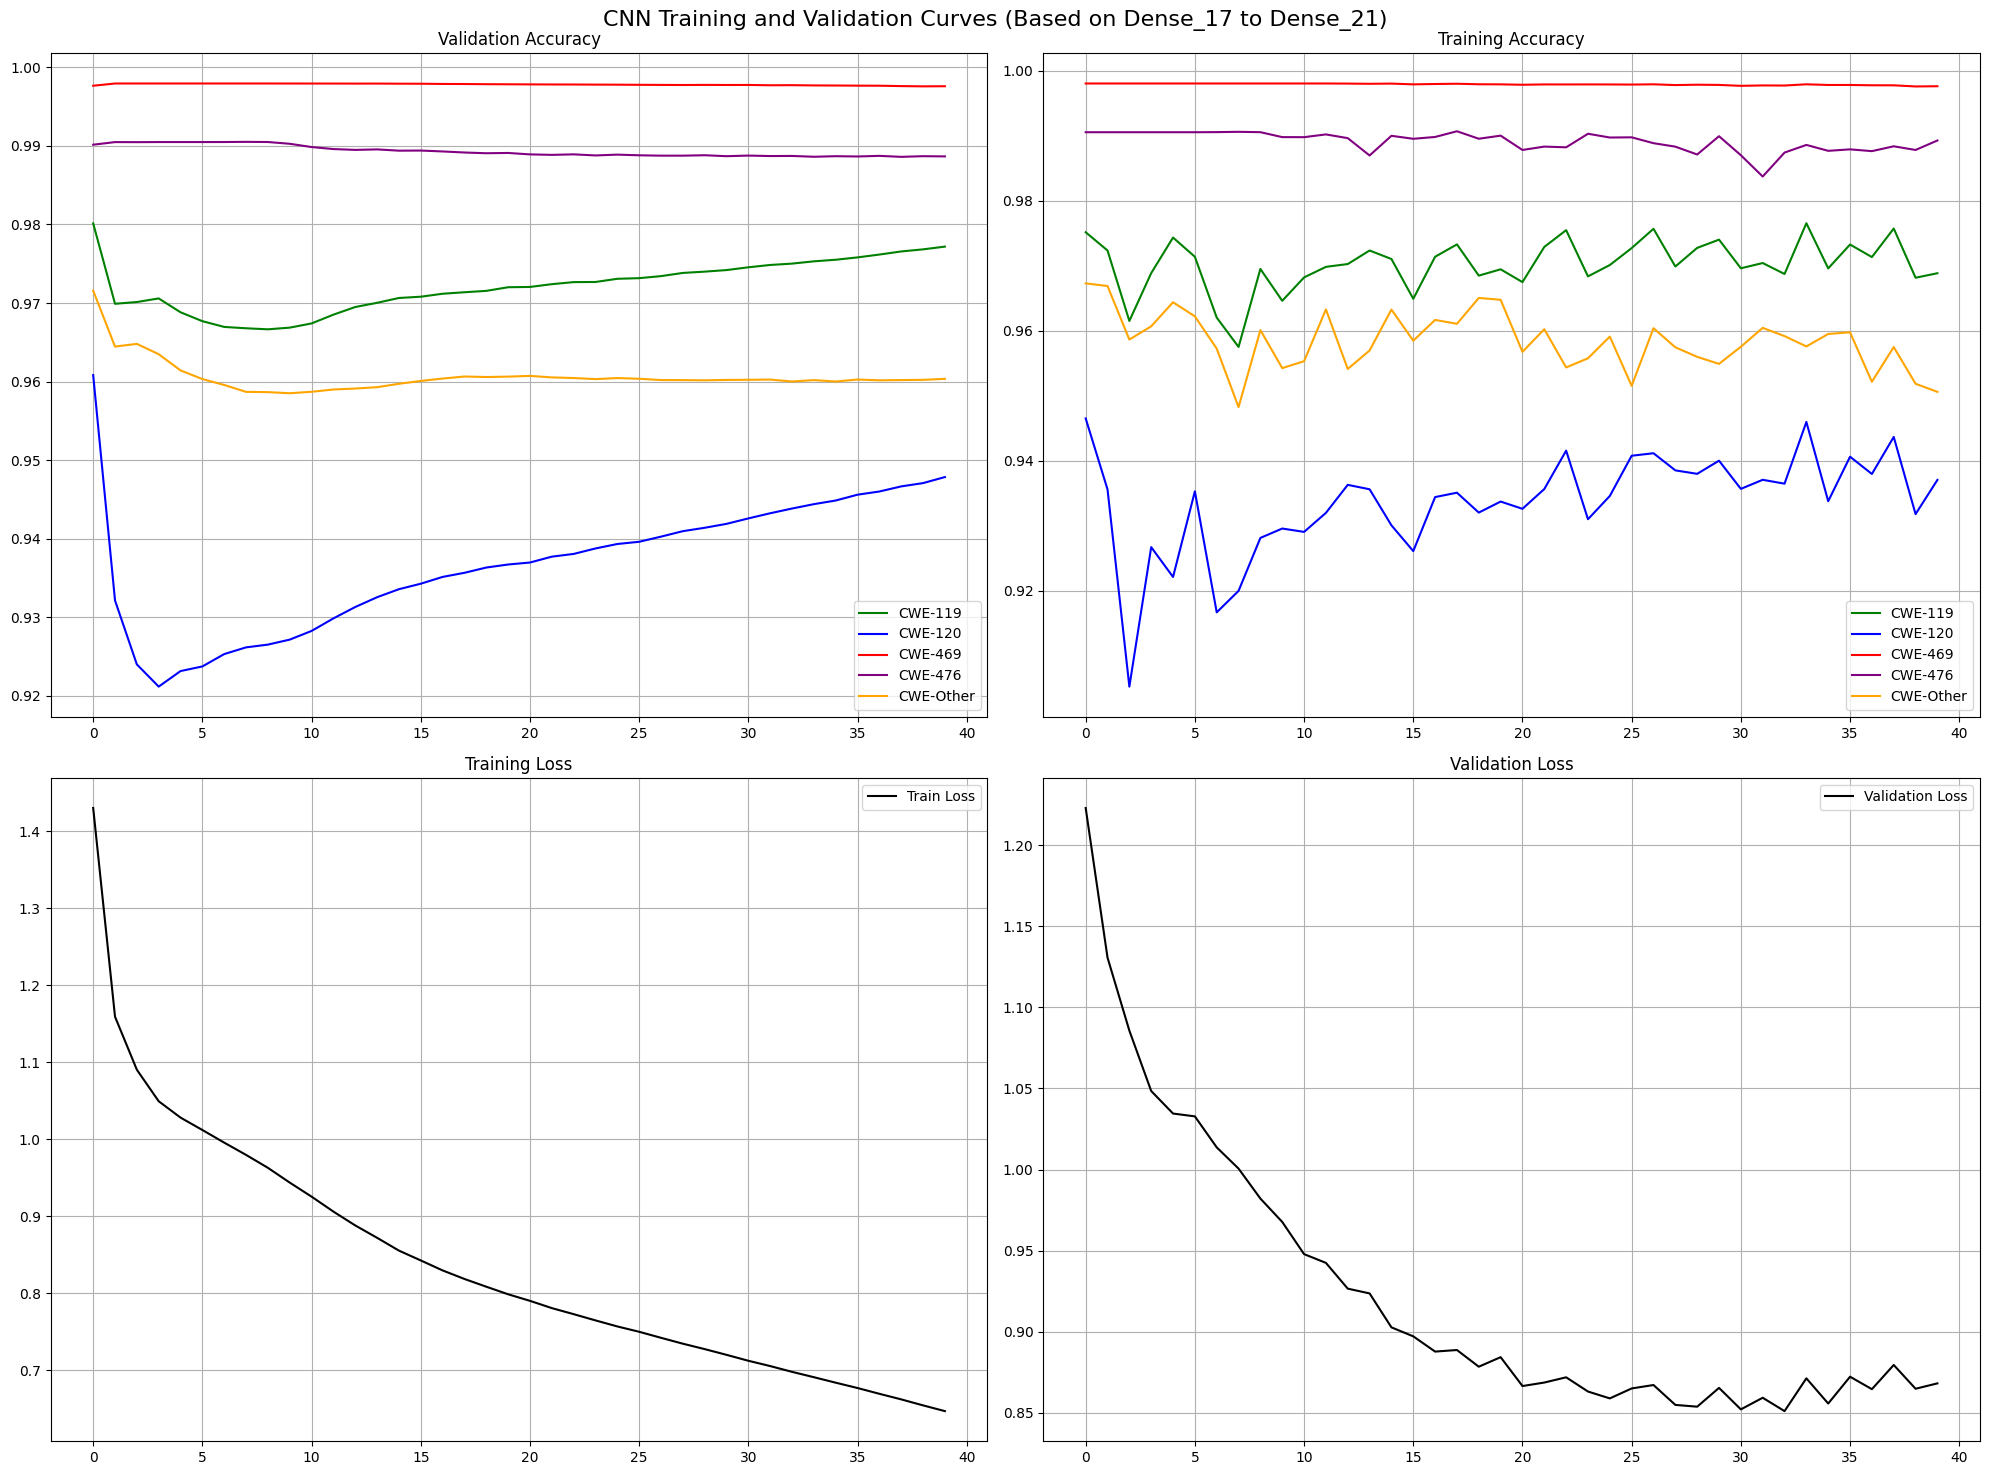

In [57]:
import matplotlib.pyplot as plt

# Correct epochs range
epochs_range = range(len(history_data['loss']))

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('CNN Training and Validation Curves (Based on Dense_17 to Dense_21)', fontsize=16)

# Top-Left: Validation Accuracy for each output
axs[0, 0].plot(epochs_range, history_data['dense_17_accuracy'], label='CWE-119', color='green')
axs[0, 0].plot(epochs_range, history_data['dense_18_accuracy'], label='CWE-120', color='blue')
axs[0, 0].plot(epochs_range, history_data['dense_19_accuracy'], label='CWE-469', color='red')
axs[0, 0].plot(epochs_range, history_data['dense_20_accuracy'], label='CWE-476', color='purple')
axs[0, 0].plot(epochs_range, history_data['dense_21_accuracy'], label='CWE-Other', color='orange')
axs[0, 0].set_title('Validation Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Top-Right: Training Accuracy for each output
axs[0, 1].plot(epochs_range, history_data['val_dense_17_accuracy'], label='CWE-119', color='green')
axs[0, 1].plot(epochs_range, history_data['val_dense_18_accuracy'], label='CWE-120', color='blue')
axs[0, 1].plot(epochs_range, history_data['val_dense_19_accuracy'], label='CWE-469', color='red')
axs[0, 1].plot(epochs_range, history_data['val_dense_20_accuracy'], label='CWE-476', color='purple')
axs[0, 1].plot(epochs_range, history_data['val_dense_21_accuracy'], label='CWE-Other', color='orange')
axs[0, 1].set_title('Training Accuracy')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Bottom-Left: Training Loss
axs[1, 0].plot(epochs_range, history_data['loss'], label='Train Loss', color='black')
axs[1, 0].set_title('Training Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Bottom-Right: Validation Loss
axs[1, 1].plot(epochs_range, history_data['val_loss'], label='Validation Loss', color='black')
axs[1, 1].set_title('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


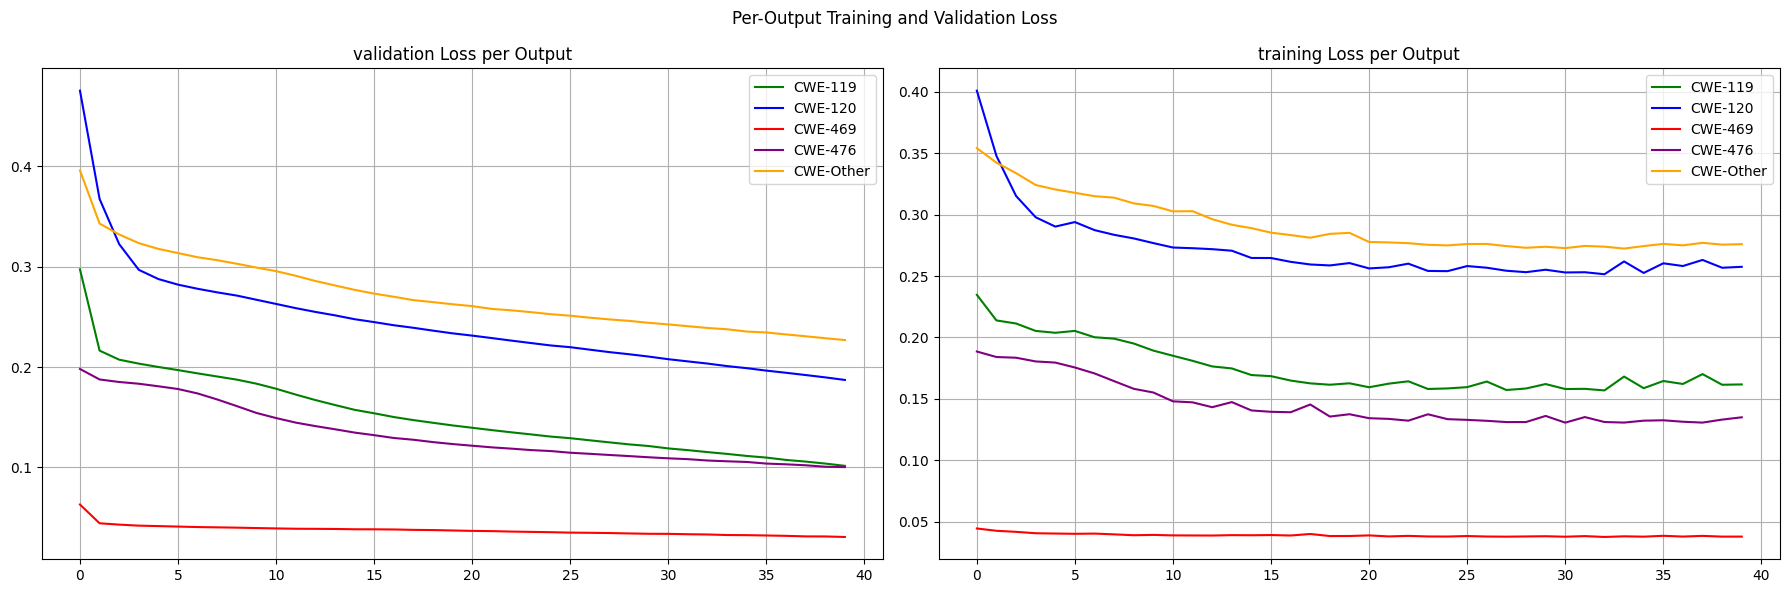

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Per-Output Training and Validation Loss')

# validation Loss per output
axs[0].plot(epochs_range, history_data['dense_17_loss'], label='CWE-119', color='green')
axs[0].plot(epochs_range, history_data['dense_18_loss'], label='CWE-120', color='blue')
axs[0].plot(epochs_range, history_data['dense_19_loss'], label='CWE-469', color='red')
axs[0].plot(epochs_range, history_data['dense_20_loss'], label='CWE-476', color='purple')
axs[0].plot(epochs_range, history_data['dense_21_loss'], label='CWE-Other', color='orange')
axs[0].set_title('validation Loss per Output')
axs[0].legend()
axs[0].grid(True)

# training Loss per output
axs[1].plot(epochs_range, history_data['val_dense_17_loss'], label='CWE-119', color='green')
axs[1].plot(epochs_range, history_data['val_dense_18_loss'], label='CWE-120', color='blue')
axs[1].plot(epochs_range, history_data['val_dense_19_loss'], label='CWE-469', color='red')
axs[1].plot(epochs_range, history_data['val_dense_20_loss'], label='CWE-476', color='purple')
axs[1].plot(epochs_range, history_data['val_dense_21_loss'], label='CWE-Other', color='orange')
axs[1].set_title('training Loss per Output')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
